**Background and Context:**

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.


**Data Description:**

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

**Dataset:**

The dataset has the following columns:

*   tweet_id
*   airline_sentiment                                               
*   airline_sentiment_confidence                               
*  negativereason                                                   
*  negativereason_confidence                                    
*  airline 
*  airline_sentiment_gold                                              
*   name     
*   negativereason_gold 
*   retweet_count
*   text
*   tweet_coord
*   tweet_created
*   tweet_location 
*   user_timezone

**Objective:**

To implement a sentiment analysis job about the problems of each major U.S. airline. 

**Learning Outcomes:**

*   Basic understanding of text pre-processing.
*   What to do after text pre-processing
*   Bag of words
*   Tf-idf
*   Build the classification model.
*   Evaluate the Model

In [1]:
!pip install textsearch
!pip install contractions
!pip install tqdm

     |████████████████████████████████| 106 kB 4.2 MB/s 
     |████████████████████████████████| 287 kB 26.6 MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import string as s

import re
from bs4 import BeautifulSoup
import unicodedata
import contractions
import spacy


import nltk               # Import Natural Language Tool-Kit.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.


from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.metrics import classification_report         # Import Classification report
from sklearn.model_selection import cross_val_score      

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive')

Mounted at /content/drive


In [4]:
data= pd.read_csv('My Drive/Colab Notebooks/twitter_sentiment/Tweets.csv')

In [5]:
# Check out the data
data.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**Exploratory Data Analysis(EDA)**

In [6]:
data.shape               # print shape of data.

(14640, 15)

In [7]:
data.info()    #information of all columns in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
# view some basic statistical details like percentile, mean, std etc. of a data frame of numeric values. 
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [9]:
data.isnull().sum(axis=0) 

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [10]:
#get the unique values of every column
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [11]:
unidf = return_unique_values(data)
print(unidf)

                        Features  Uniques
0                       tweet_id    14485
1              airline_sentiment        3
2   airline_sentiment_confidence     1023
3                 negativereason       10
4      negativereason_confidence     1410
5                        airline        6
6         airline_sentiment_gold        3
7                           name     7701
8            negativereason_gold       13
9                  retweet_count       18
10                          text    14427
11                   tweet_coord      832
12                 tweet_created    14247
13                tweet_location     3081
14                 user_timezone       85


In [12]:
airlines = data['airline'].unique()
airlines

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

Distribution of all tweets among each airline & plot the distribution of sentiment across all the tweets.

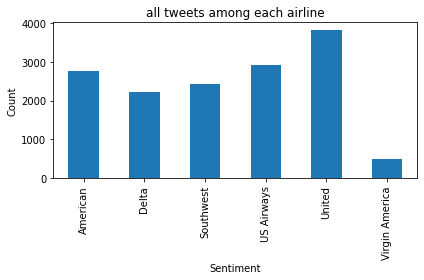

In [13]:
all_by_airline= data.groupby(['airline']).count().iloc[:,0]
ax = all_by_airline.plot(kind = 'bar', title = 'all tweets among each airline')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

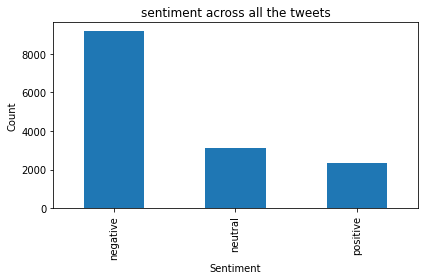

In [14]:
all_by_sentiment= data.groupby(['airline_sentiment']).count().iloc[:,0]
ax = all_by_sentiment.plot(kind = 'bar', title = 'sentiment across all the tweets')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

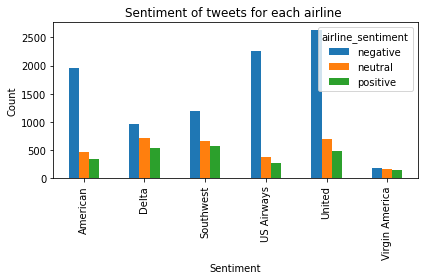

In [15]:
sentiment_by_airline = data.groupby(['airline','airline_sentiment']).count().iloc[:,0]
ax = sentiment_by_airline.unstack(1).plot(kind = 'bar', title = 'Sentiment of tweets for each airline ')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

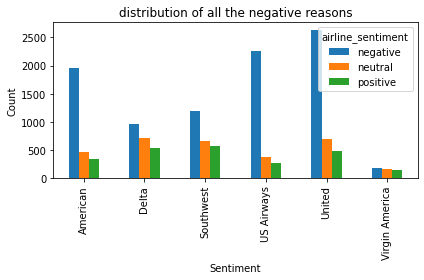

In [16]:
sentiment_by_airline = data.groupby(['airline','airline_sentiment']).count().iloc[:,0]
ax = sentiment_by_airline.unstack(1).plot(kind = 'bar', title = 'distribution of all the negative reasons')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

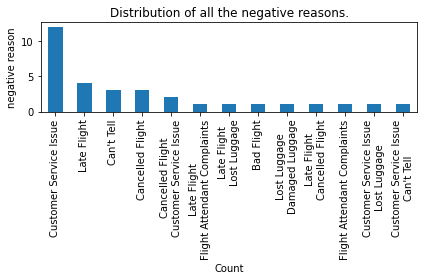

In [17]:
negative_reasons=data[data['airline_sentiment']== 'negative']['negativereason_gold']
negative_reasons=negative_reasons.dropna()
ax = negative_reasons.value_counts().plot(kind = 'bar', title = 'Distribution of all the negative reasons.')
ax.set_ylabel('negative reason')
ax.set_xlabel('Count')
plt.tight_layout()
plt.show()

In [18]:
#creating word cloud for positive reviews
positive_tweet=data[data['airline_sentiment']== 'positive']
words = ' '.join(positive_tweet['text'])
cleaned_word = " ".join([word for word in words.split()])

In [19]:
from wordcloud import WordCloud,STOPWORDS

In [20]:
wordcloud = WordCloud(stopwords='STOPWORDS',
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)


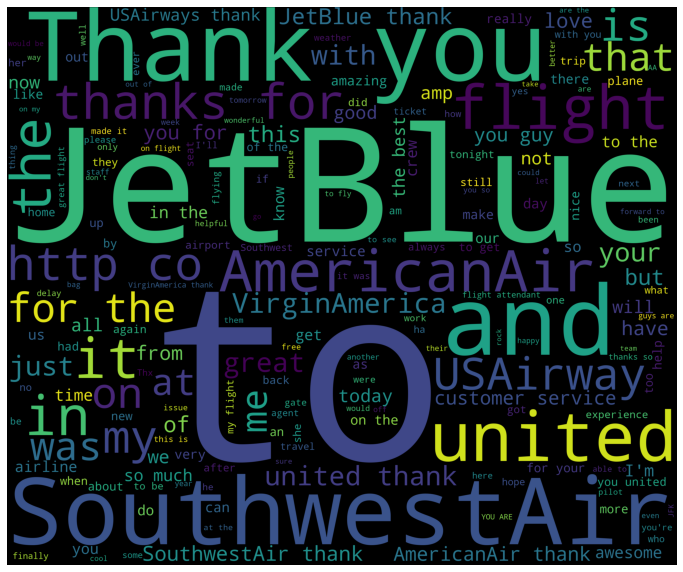

In [21]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

For positive feedback, words like "Thank", "you" and "JetBlue", and "SouthwestAir" are the most frequent ones. This means people appreciate the airlines when they offer a good flight experience.

In [22]:
#creating word cloud for negative reviews
negative_tweet=data[data['airline_sentiment']== 'negative']
words = ' '.join(negative_tweet['text'])
cleaned_word = " ".join([word for word in words.split()])

In [23]:
wordcloud = WordCloud(stopwords='STOPWORDS',
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

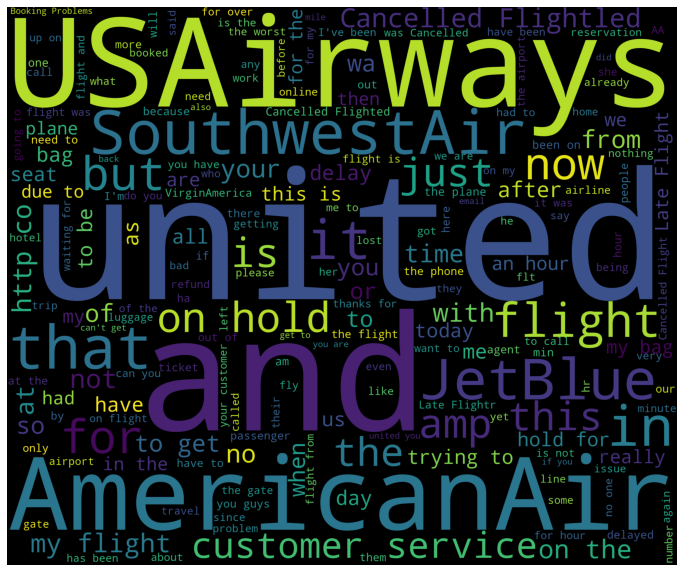

In [24]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In negative tweetts, some of the frequent words mentioned are "United", "USAirways", "AmericanAir", "On hold" "Cancelled", and "Customer Service".

**Understanding of Data Columns**

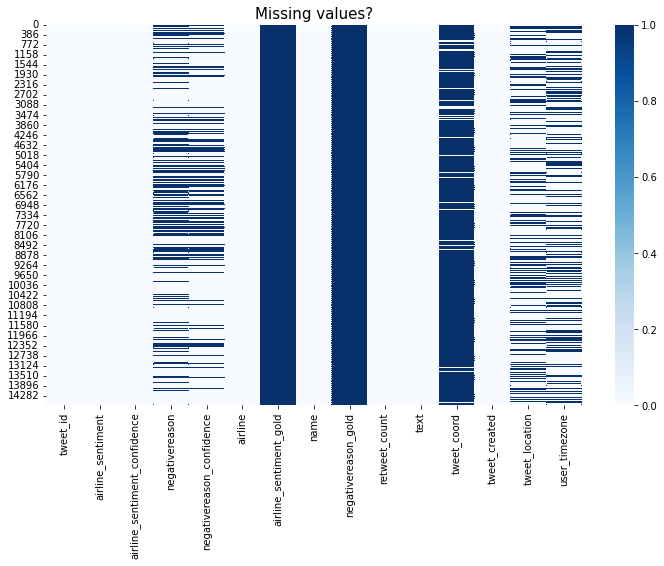

In [25]:
plt.figure(figsize=(12,7))
sns.heatmap(data.isnull(), cmap = "Blues")                       #Visualization of missing value using heatmap
plt.title("Missing values?", fontsize = 15)
plt.show()

The lines in the above heatmap will visualize the location of missing values (i.e. the missing value indexes in the dataframe).

There are three columns that have a large number of null values and are not valueable information:
   * negativereason_gold, 
   * airline_sentiment_gold
   * tweet_coord

We will drop these columns in order to keep our dataset clean.

We will also drop 
   * name 
   * tweet_location 
   * tweet_created 
   * user_timezone 
   * retweet_count
since these data columns do not contribute to our analysis.

In [26]:
data.drop(['negativereason_gold','airline_sentiment_gold','tweet_coord'], axis=1, inplace=True)

data.drop(['name','tweet_id'], axis=1, inplace=True)
data.drop(['tweet_location','tweet_created','user_timezone', 'retweet_count'], axis=1, inplace=True)
data.drop(['airline_sentiment_confidence','negativereason','negativereason_confidence','airline'], axis=1, inplace=True)


In [27]:
data.shape

(14640, 2)

In [28]:
data.head(5)


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


**Data Pre - Processing**

In [29]:
nlp = spacy.load('en', parse=False, tag=False, entity=False)
ps = nltk.porter.PorterStemmer()

#remove the html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)


def spacy_lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def simple_stemming(text, stemmer=ps):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def tokenize_text(text):
  text = nltk.word_tokenize(text)  # Tokenization of data
  return text

def convert_lowercase(text):
  return text.lower()


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def remove_special_characters(text):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text



def clean_text(text):
    text = strip_html_tags(text)
    #text = tokenize_text(text)
    text = replace_contractions(text)
    text = spacy_lemmatize_text(text)
    text = simple_stemming(text)
    text = remove_numbers(text)
    text = convert_lowercase(text)
    text = remove_url(text)
    text = remove_mention(text)
    text = remove_special_characters(text)
    text = remove_accented_chars(text)
    text = remove_stopwords(text)

    
    return text
data['text'] = data['text'].apply(lambda x: clean_text(x))
data.head()

,airline_sentiment,text
0,neutral,say
1,positive,plu add commerci experi tacki
2,neutral,today must mean need take anoth trip
3,negative,realli aggress blast obnoxi entertain guest fa...
4,negative,realli big bad thing


**Supervised Learning for Sentiment Analysis**

Bag of Words (CountVectorizer)

In [30]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

Count_vec = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features = Count_vec.fit_transform(data['text'])
data_features = data_features.toarray()                        # Convert the data features to array.

In [31]:
data_features.shape       #Shape of the feature vector

(14640, 1000)

In [32]:
X = data_features

y = data.airline_sentiment

In [33]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [34]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [35]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

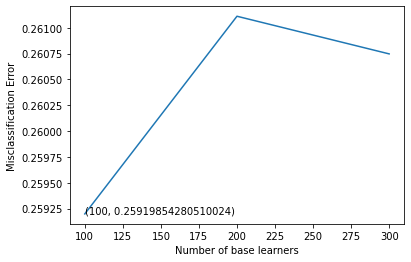

In [36]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [37]:
# Training the best model and calculating accuracy on test data .
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['negative','neutral' , 'positive']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.87      2627
     neutral       0.49      0.45      0.47       577
    positive       0.65      0.66      0.65       456

    accuracy                           0.79      3660
   macro avg       0.67      0.66      0.67      3660
weighted avg       0.78      0.79      0.78      3660

Accuracy of the model is :  0.7857923497267759


[[2315  208  104]
 [ 257  260   60]
 [  97   58  301]]


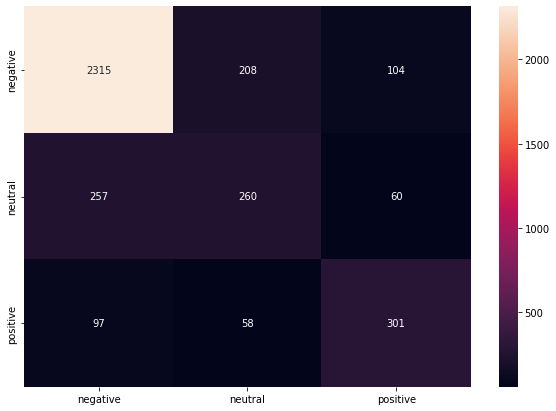

In [38]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, count_vectorizer_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative','neutral' , 'positive']],
                  columns = [i for i in ['negative','neutral' , 'positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

thank,hour,great,delay,flight,love,bag,awesom,good,whi,hold,get,bad,custom,cancel,thi,amaz,would,fli,servic,make,wait,time,pleas,help,plane,call,fleet,still,airlin,go,hr,ani,tell,need,fleek,follow,say,tri,lose,
 
 


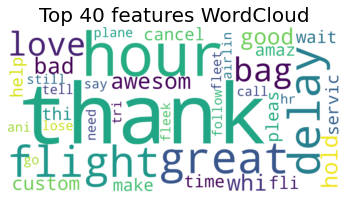

In [39]:
all_features = Count_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### **TF-IDF**

**Term Frequency -  Inverse Document Frequency:** It makes sure that less importance is given to the most frequent words, and it also considers less frequent words.

In [40]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=500)
data_features = tfidf_vect.fit_transform(data["text"])

data_features = data_features.toarray()

data_features.shape     #feature shape

(14640, 500)

In [41]:
X = data_features

y = data.airline_sentiment

In [42]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [43]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [44]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

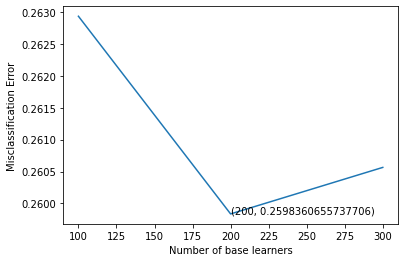

In [45]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [46]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
tf_idf_predicted = clf.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['negative','neutral' , 'positive']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      2627
     neutral       0.56      0.42      0.48       577
    positive       0.67      0.63      0.65       456

    accuracy                           0.80      3660
   macro avg       0.69      0.65      0.67      3660
weighted avg       0.78      0.80      0.79      3660

Accuracy of the model is :  0.7953551912568306


[[2382  160   85]
 [ 281  241   55]
 [ 138   30  288]]


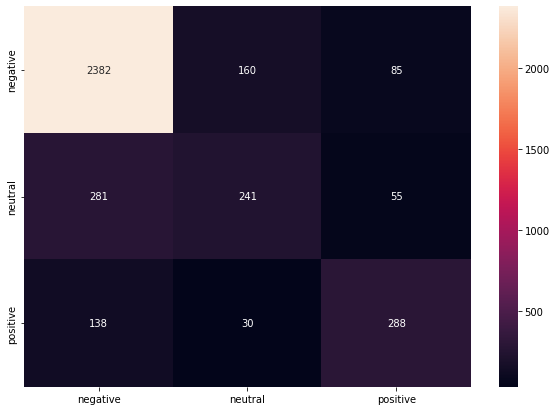

In [47]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, tf_idf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative','neutral' , 'positive']],
                  columns = [i for i in ['negative','neutral' , 'positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

thank, flight, great, hour, delay, love, good, get, awesom, bag, whi, hold, thi, fli, cancel, custom, bad, ani, amaz, make, would, pleas, fleek, servic, airlin, plane, need, go, wait, time, help, dm, call, follow, fleet, know, still, well, day, like, 
 
 


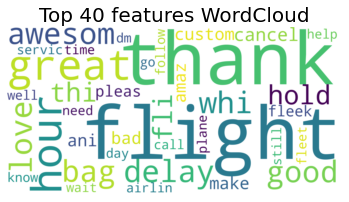

In [48]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

* **TF-IDF shows a better performance than Count Vectorizer**, because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.

**Conclusions**

This data showed that twitter comments towards US Airlines are typically negative. This might be because the data is skewed and unhappy passengers tweet about their bad experience more than happy customers. 

The most commonly mentioned reason is "customer service", followed by "late flight".  This data showed that happy customers also tweet about thier positive experience and tend to "Thank" the crew and airline.

Therefore improving the customer service will definitely have a positive effect on the passengers' experience. 

We were able to classify the sentiment of a tweet with an accuracy of 79% using our TF-IDF model.
